In [26]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt


In [27]:
# Procura todos os arquivos CSV na pasta "data"
files = glob.glob("data/*.csv")

dfs = []
for f in files:
    # Lê o arquivo CSV
    df = pd.read_csv(f)
    
    # Extrai o nome do arquivo (sem o caminho) e remove a extensão
    base = os.path.basename(f)  # Ex: "2020_1.csv"
    semestre = os.path.splitext(base)[0].replace("_", ".")  # Ex: "2020.1"
    
    # Adiciona a coluna "Semestre"
    df["Semestre"] = semestre
    dfs.append(df)

# Concatena todos os DataFrames em um único
df_consolidado = pd.concat(dfs, ignore_index=True)

In [28]:

# Salva o DataFrame consolidado em um novo arquivo CSV
df_consolidado.to_csv("consolidado.csv", index=False)

# Verificar as repetições

In [29]:
# Carrega o CSV consolidado
df = pd.read_csv("consolidado.csv")

# Conta quantas vezes cada 'Discente' aparece
contagem = df["Discente"].value_counts()

print(contagem)

Discente
150048793 - Yasmine Silveira Andrade               2
140171215 - Wilton Miro Barros Junior              2
160019893 - Vitor Guedes da Silva                  2
160018234 - Sofia Consolmagno Fontes               2
180148273 - Daniel de Melo Cardoso                 2
                                                  ..
170009530 - ERICK ROLLEMBERG CRUCIOL FIGUEIREDO    1
180031546 - Emmanuelle Silva                       1
180149407 - Bruno Cesar de Oliveira Frazao         1
190041935 - Amanda Cristina Teixeira Pinto         1
190098708 - Alisson Ferreira da Silva              1
Name: count, Length: 312, dtype: int64


# Vamos eliminar as repetições

In [30]:

# Define uma ordem de prioridade para "Tipo de Saída"
# Aqui, "INTEGRALIZAÇÃO DE DISCENTE" tem prioridade maior (0) que "CONCLUÍDO" (1)
priority = {"INTEGRALIZAÇÃO DE DISCENTE": 0, "CONCLUÍDO": 1}
df['rank'] = df['Tipo de Saída'].map(priority)

# Se houver algum valor não mapeado, podemos atribuir um número alto
df['rank'] = df['rank'].fillna(2)

# Ordena por 'Discente' e pela coluna 'rank'
df_sorted = df.sort_values(by=['Discente', 'rank'])

# Remove duplicatas, mantendo a primeira ocorrência de cada 'Discente'
df_dedup = df_sorted.drop_duplicates(subset='Discente', keep='first')

# Remove a coluna auxiliar 'rank' (opcional)
df_dedup = df_dedup.drop(columns='rank')

df_dedup.to_csv("consolidado_filtrado.csv")

/tmp/ipykernel_76475/3324362242.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


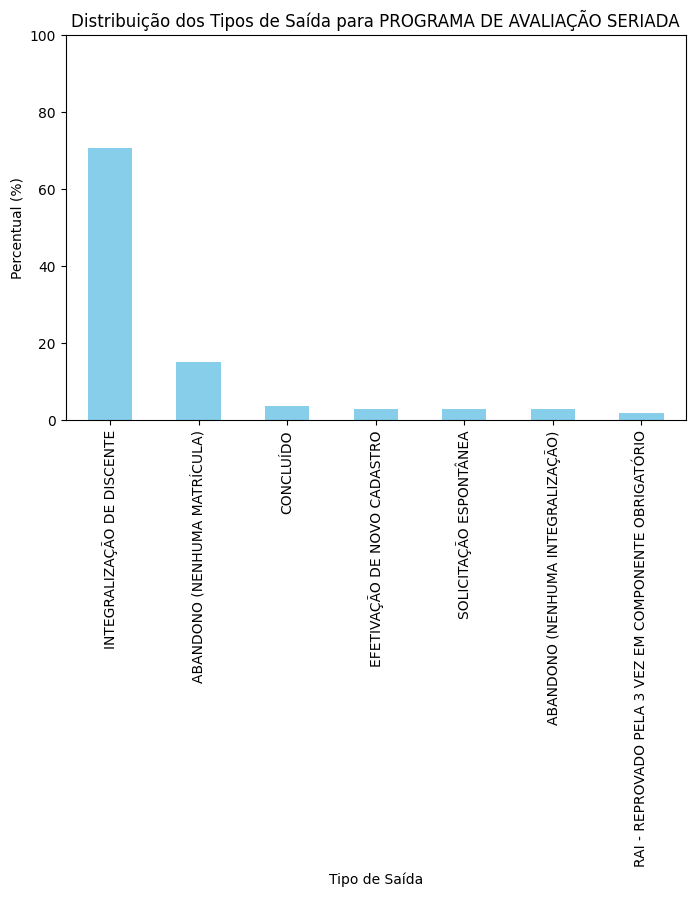

/tmp/ipykernel_76475/3324362242.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


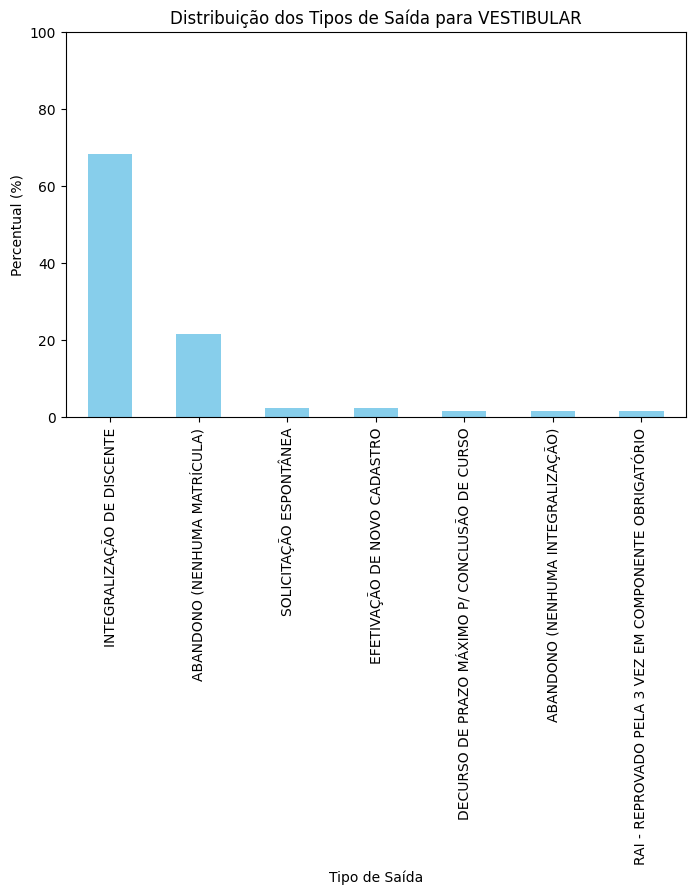

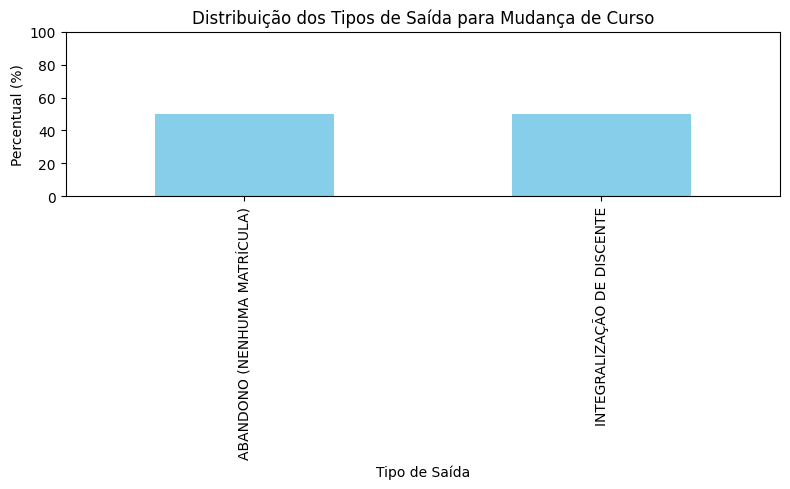

/tmp/ipykernel_76475/3324362242.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


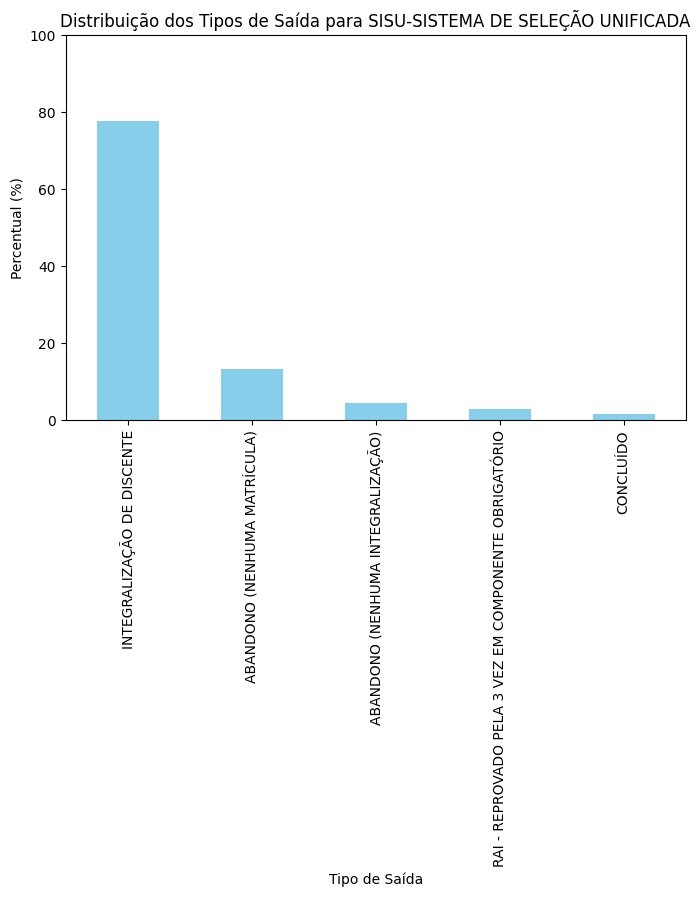

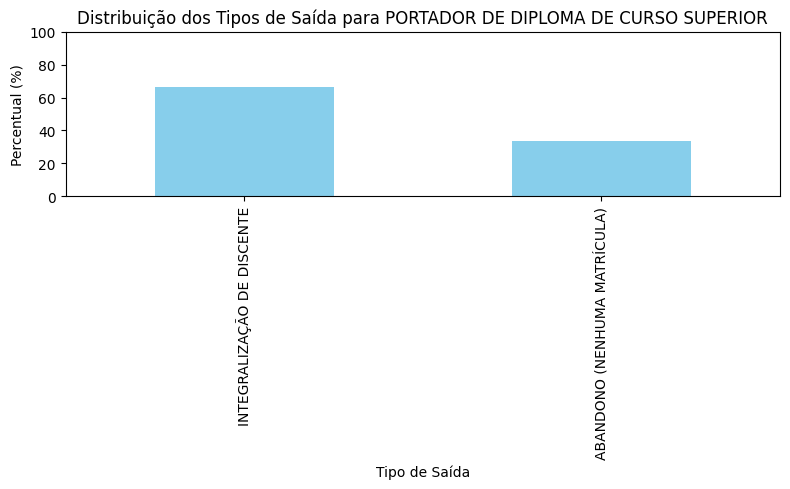

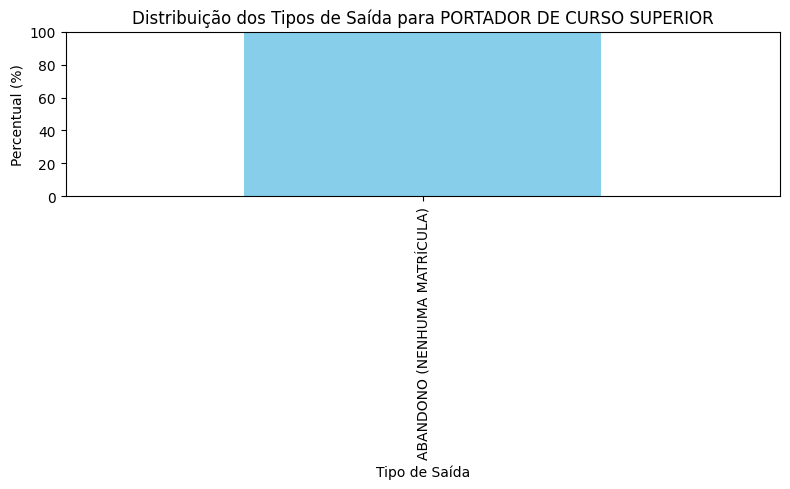

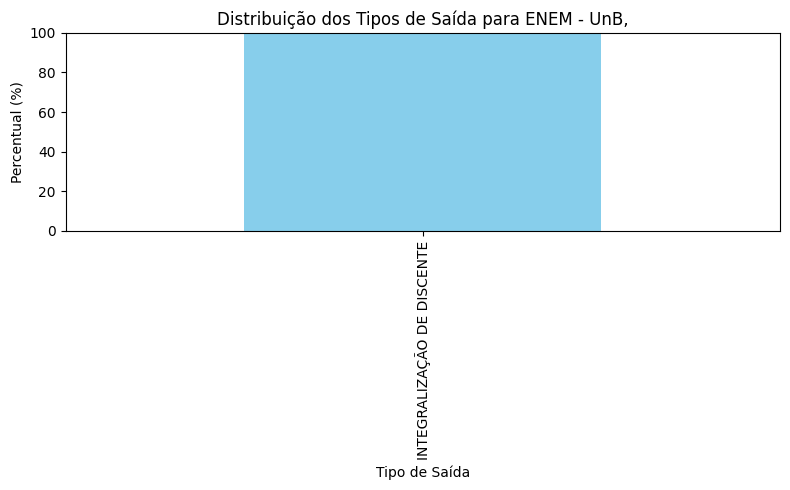

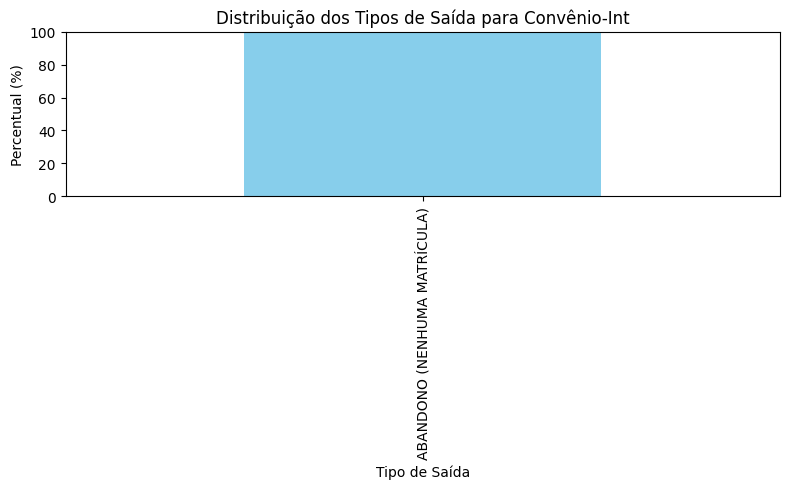

/tmp/ipykernel_76475/3324362242.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


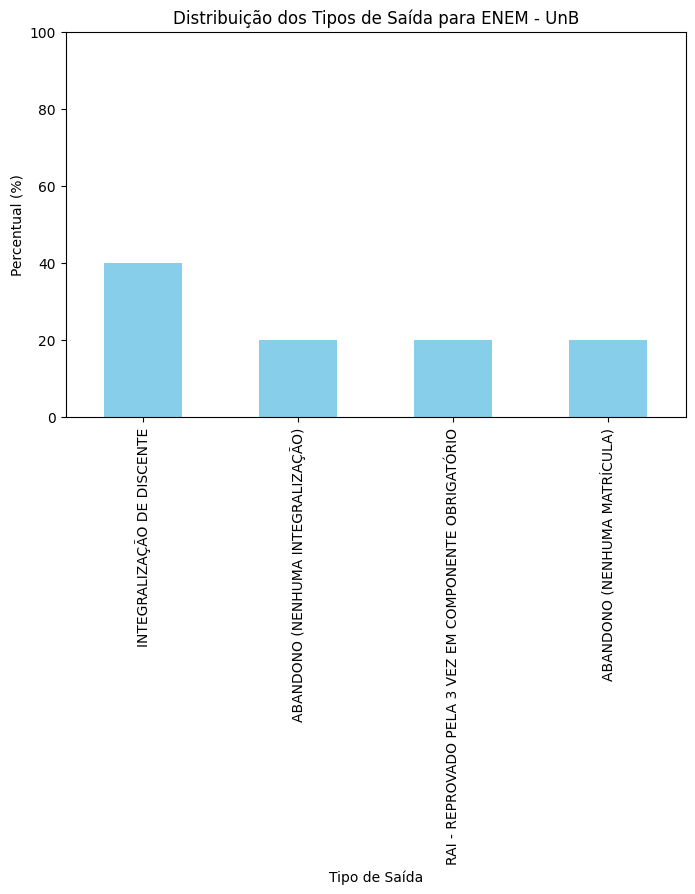

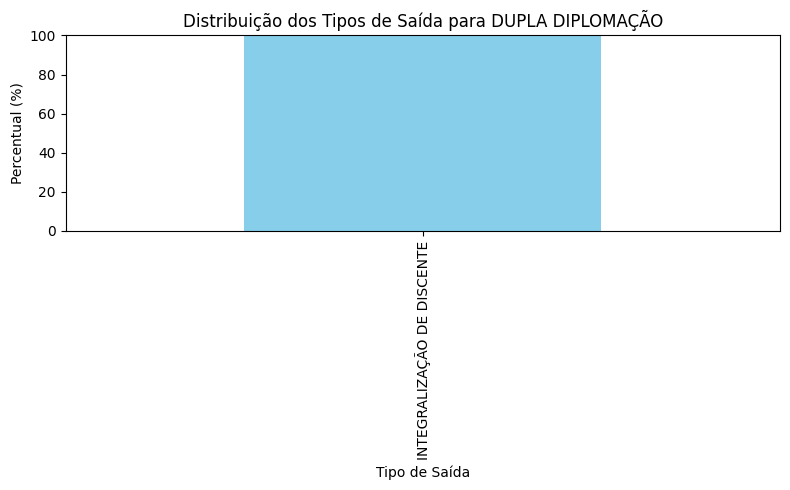

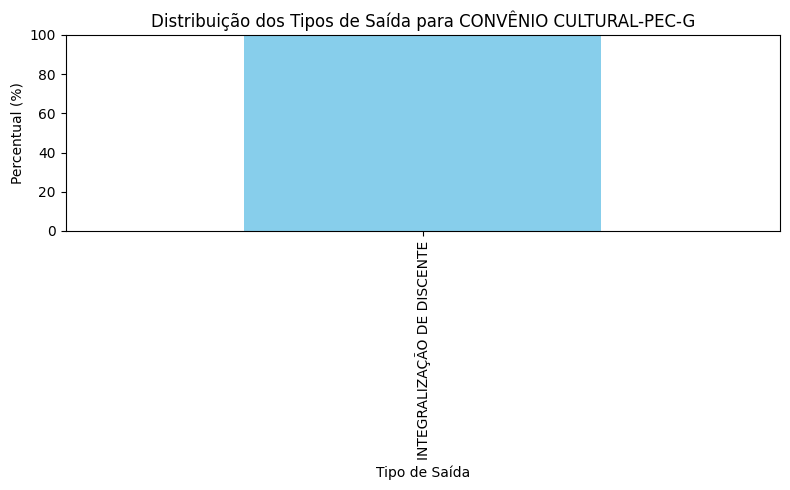

In [31]:


# Carregar o CSV consolidado (supondo que o arquivo consolidado já foi gerado)
df = pd.read_csv("consolidado_filtrado.csv")

# Obtém os tipos únicos de entrada
tipos_entrada = df["Tipo de Entrada"].unique()

# Itera sobre cada tipo de entrada para gerar o gráfico
for entrada in tipos_entrada:
    # Filtra os registros para o tipo de entrada atual
    df_entrada = df[df["Tipo de Entrada"] == entrada]
    
    # Calcula a distribuição percentual dos tipos de saída
    distrib = df_entrada["Tipo de Saída"].value_counts(normalize=True) * 100
    
    # Cria um gráfico de barras para o tipo de entrada atual
    plt.figure(figsize=(8, 5))
    distrib.plot(kind="bar", color="skyblue")
    plt.title(f"Distribuição dos Tipos de Saída para {entrada}")
    plt.ylabel("Percentual (%)")
    plt.xlabel("Tipo de Saída")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()



In [34]:
# Cria a tabela dinâmica:
# - As linhas serão os "Tipo de Entrada"
# - As colunas serão os "Tipo de Saída"
# - As células terão os percentuais (normalizados por linha)
# 1. Cria a tabela dinâmica com percentuais dos Tipos de Saída para cada Tipo de Entrada
pivot_table = pd.crosstab(df["Tipo de Entrada"], df["Tipo de Saída"], normalize="index") * 100
pivot_table = pivot_table.round(2)

# Combina as colunas "CONCLUÍDO" e "INTEGRALIZAÇÃO DE DISCENTE" em uma só: "CONCLUÍDO"
if "CONCLUÍDO" in pivot_table.columns and "INTEGRALIZAÇÃO DE DISCENTE" in pivot_table.columns:
    pivot_table["CONCLUÍDO"] = pivot_table["CONCLUÍDO"] + pivot_table["INTEGRALIZAÇÃO DE DISCENTE"]
    pivot_table = pivot_table.drop(columns=["INTEGRALIZAÇÃO DE DISCENTE"])

# 2. Calcula o total de alunos para cada Tipo de Entrada
total_counts = df["Tipo de Entrada"].value_counts().to_frame(name="Total Alunos")
total_counts.index.name = "Tipo de Entrada"

# Junta a contagem total com a tabela de percentuais
result_table = total_counts.join(pivot_table)

# Reorganiza as colunas para que "Total Alunos" seja a primeira
cols = result_table.columns.tolist()
cols = ["Total Alunos"] + [col for col in cols if col != "Total Alunos"]
result_table = result_table[cols]

# 3. Cria a última linha "Total"
total_alunos = len(df)
overall_percent = (df["Tipo de Saída"].value_counts(normalize=True) * 100).round(2)

# Combina os percentuais de "CONCLUÍDO" e "INTEGRALIZAÇÃO DE DISCENTE" para o total
overall_concluido = overall_percent.get("CONCLUÍDO", 0) + overall_percent.get("INTEGRALIZAÇÃO DE DISCENTE", 0)
overall_percent["CONCLUÍDO"] = overall_concluido
if "INTEGRALIZAÇÃO DE DISCENTE" in overall_percent.index:
    overall_percent = overall_percent.drop("INTEGRALIZAÇÃO DE DISCENTE")

total_row = {"Total Alunos": total_alunos}
for col in result_table.columns:
    if col == "Total Alunos":
        continue
    total_row[col] = overall_percent.get(col, 0.0)

total_row_df = pd.DataFrame(total_row, index=["Total"])

# Concatena a linha "Total" com a tabela final
result_table = pd.concat([result_table, total_row_df])
result_table

,Total Alunos,ABANDONO (NENHUMA INTEGRALIZAÇÃO),ABANDONO (NENHUMA MATRÍCULA),CONCLUÍDO,DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO,EFETIVAÇÃO DE NOVO CADASTRO,RAI - REPROVADO PELA 3 VEZ EM COMPONENTE OBRIGATÓRIO,SOLICITAÇÃO ESPONTÂNEA
VESTIBULAR,120,1.67,21.67,68.33,1.67,2.50,1.67,2.50
PROGRAMA DE AVALIAÇÃO SERIADA,106,2.83,15.09,74.52,0.00,2.83,1.89,2.83
SISU-SISTEMA DE SELEÇÃO UNIFICADA,67,4.48,13.43,79.10,0.00,0.00,2.99,0.00
Mudança de Curso,6,0.00,50.00,50.00,0.00,0.00,0.00,0.00
ENEM - UnB,5,20.00,20.00,40.00,0.00,0.00,20.00,0.00
PORTADOR DE DIPLOMA DE CURSO SUPERIOR,3,0.00,33.33,66.67,0.00,0.00,0.00,0.00
PORTADOR DE CURSO SUPERIOR,1,0.00,100.00,0.00,0.00,0.00,0.00,0.00
"ENEM - UnB,",1,0.00,0.00,100.00,0.00,0.00,0.00,0.00
Convênio-Int,1,0.00,100.00,0.00,0.00,0.00,0.00,0.00
DUPLA DIPLOMAÇÃO,1,0.00,0.00,100.00,0.00,0.00,0.00,0.00


In [35]:
result_table.to_csv("egresso_eletronica.csv")
